In [1]:
# trying to automate the process of cleaning up sonde data, but having little success...
# the methods from the bl class used a different file format, so I can't just copy those methods :/
# having issues converting from datetime and plotting data with nans present...

# using the "raw" data files found on NOAA's website isn't helpful... don't even bother with those!

In [2]:
# import...
import numpy as np
import xarray as xr
import os
import matplotlib.pyplot as plt
import warnings
import pandas as pd

os.chdir("/Users/etmu9498/research/code/scripts")
import make_plots_new_heights
import make_plots
import tc_metadata
import helper_fns


In [11]:
# look at sondes first
# also looking at sondes!
sonde_path_test = '/Users/etmu9498/research/data/dropsondes/2022/noaa'
sonde_list = make_plots.load_sondes( sonde_path_test, print_files=False)

# load one example sonde
os.chdir( sonde_path_test)
sonde = xr.open_dataset( sonde_list[ 0])

sonde_path2 = '/Users/etmu9498/research/data/dropsondes/2022/aoml'
sonde_list2 = make_plots.load_sondes( sonde_path2, print_files=False)
# load one example sonde
os.chdir( sonde_path2)
sonde = xr.open_dataset( sonde_list2[ 10])
sonde

<xarray.Dataset>
Dimensions:         (time: 879, obs: 1)
Coordinates:
  * time            (time) datetime64[ns] 2022-09-20T11:44:04.789993286 ... 2...
    lat             (time) float32 ...
    lon             (time) float32 ...
    gpsalt          (time) float32 ...
Dimensions without coordinates: obs
Data variables: (12/27)
    trajectory      |S1 ...
    launch_time     datetime64[ns] ...
    pres            (time) float32 ...
    tdry            (time) float32 ...
    dp              (time) float32 ...
    rh              (time) float32 ...
    ...              ...
    reference_rh    (obs) float32 ...
    reference_wspd  (obs) float32 ...
    reference_wdir  (obs) float32 ...
    reference_lat   (obs) float32 ...
    reference_lon   (obs) float32 ...
    reference_alt   (obs) float32 ...
Attributes: (12/93)
    Conventions:            CF-1.6
    RepoRevision:           V3.4.7
    RepoLastChangedDate:    Fri May 6 14:29:37 2022 -0600
    RepoId:                 14c38ba5b54ddaa3e2c5c0669fd4f5b756c345c2
    RepoBranch:             HEAD
    featureType:            trajectory
    ...                     ...
    WindQCDev:              999
    WindQCWL:               30
    WindSats:               6
    WindSmoothWL:           10
    WindVVPresWL:           5
    WindVVdelta:            2.5

In [12]:
# exploring data types, size, etc for sondes

# print( sonde.time.values)
# print( sonde.theta.values)
# print( sonde.pres.values)
# print( sonde.theta.values)

# print( len( sonde.time))
# print( len( sonde.pres))
# print( len( sonde.theta))

# print( type( sonde.time[0]))
# print( type( sonde.theta[0]))

In [13]:
# change from datetime to hours with a decimal point!

# issue: this code isn't picking up on the decimal from the seconds category, so timestamps are being repeated four times
# for each .25 second interval :/

datetimes = sonde.time.values
float_time = []
for val in datetimes:
    val = pd.Timestamp( val)
    
    # account for wraparound times into next day
    if val.hour + val.minute / 60 + val.second / 3600 < 6.0:
        float_time.append( 24.0 + val.hour + val.minute / 60 + val.second / 3600)
    else:
        float_time.append( val.hour + val.minute / 60 + val.second / 3600)

time = np.array( float_time)

# print( time)

In [14]:
# try masking nans in pressure and temp, etc variables to allow for proper plotting
# this works! but is honestly very annoying. Each pair of variables needs to be masked before plotting,
# because small changes in the nan count can break the matchup between the variables...

mr = sonde.mr.values
p = sonde.pres.values
u = sonde.u_wind.values
v = sonde.v_wind.values

spd = (u**2 + v**2)**.5

mask = ~np.isnan( p) & ~np.isnan( mr)

mr = mr[ mask]
p = p[ mask]

print( len (mr))
print( len( p))

427
427


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'WVMR (g/kg)')

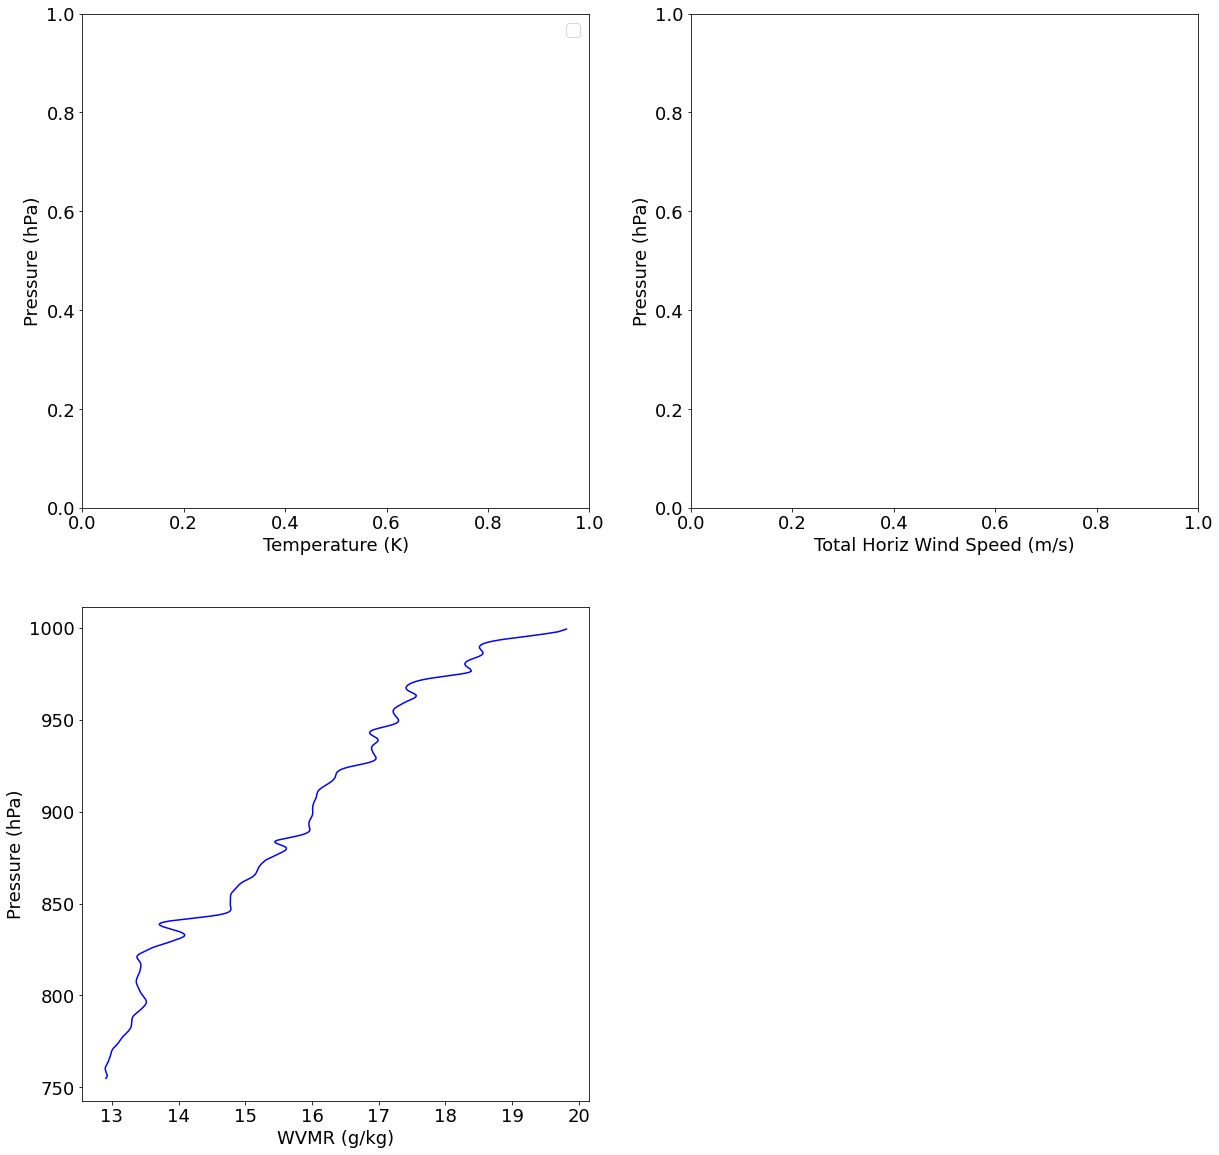

In [15]:
# make a simple plot of attributes
plt.figure( figsize=( 20, 20))
helper_fns.change_font_sizes(18, 18)

# plot potential, virtual potential, and equivalent potential temperatures! 
plt.subplot(221)
# plt.plot( sonde.theta.values, np.flip( sonde.time.values),  c='y', label='Theta')
# plt.plot( sonde.theta_e, np.flip( sonde.time.values), c='r', label='Theta E')
# plt.plot( sonde.theta_v, np.flip( sonde.time.values), c='k', label='Theta V')

# plt.plot( sonde.theta.values, sonde.pres,  c='y', label='Theta')
# plt.plot( sonde.theta_e, sonde.pres, c='r', label='Theta E')
# plt.plot( sonde.theta_v, sonde.pres, c='k', label='Theta V')

# plt.ylabel( "Time (UTC)")
plt.ylabel( "Pressure (hPa)")
plt.xlabel( "Temperature (K)")
plt.legend()

plt.subplot(222)
# plt.plot( (sonde.u_wind**2 + sonde.v_wind**2)**.5, np.flip( sonde.time.values), c='g')
# plt.plot( spd, p, c='g')

# plt.ylabel( "Time (UTC)")
plt.ylabel( "Pressure (hPa)")
plt.xlabel( "Total Horiz Wind Speed (m/s)")

plt.subplot(223)
plt.plot( mr, p, c='b')

# plt.ylabel( "Time (UTC)")
plt.ylabel( "Pressure (hPa)")
plt.xlabel( "WVMR (g/kg)")

In [10]:
# loop through every sonde: check out the pressure lims for each!
# helps to weed out bad datasets from outer rainbands from inner sondes!
for i in range( len( sonde_list)):
    os.chdir( sonde_path_test)
    sonde = xr.open_dataset( sonde_list[ i])
    
    print( "\nSonde " + str( i) + ":")
    print( np.nanmin( sonde.pres))
    print( np.nanmax( sonde.pres))


Sonde 0:
696.29596
863.52625

Sonde 1:
699.3726
1000.7214

Sonde 2:
699.94775
961.98834

Sonde 3:
695.99255
971.12354

Sonde 4:
705.2691
974.19446

Sonde 5:
703.1975
980.3189

Sonde 6:
699.0943
980.2354

Sonde 7:
699.9605
985.12616

Sonde 8:
700.435
1008.48566

Sonde 9:
756.1386
976.0013

Sonde 10:
754.90466
999.3109

Sonde 11:
755.4434
1007.51117

Sonde 12:
754.61365
1001.778

Sonde 13:
753.75354
985.24805

Sonde 14:
755.1151
965.10236

Sonde 15:
754.0821
989.6468

Sonde 16:
755.248
990.54895

Sonde 17:
754.8085
991.0757

Sonde 18:
756.0601
1002.2835

Sonde 19:
755.2086
1006.9425

Sonde 20:
748.9495
816.64056

Sonde 21:
757.4655
1005.31665

Sonde 22:
774.12286
997.90045

Sonde 23:
755.8377
984.58636

Sonde 24:
754.6186
984.2905

Sonde 25:
754.0333
984.4445

Sonde 26:
755.2599
1002.25494

Sonde 27:
755.8718
1006.9398


In [17]:
# loop through every day folder containing sonde data: how many soundings are in each folder??

os.chdir('/Users/etmu9498/research/data/dropsondes/2022/')
# print( next(os.walk('noaa')))

for folder in next(os.walk('noaa'))[1]:
    folder_path = '/Users/etmu9498/research/data/dropsondes/2022/noaa/' + folder
    
    # print the number of soundings from this day!
    sonde_list = make_plots.load_sondes( folder_path, print_files=False)
    print( "Number of Sondes in " + folder + ": " + str( len( sonde_list)) )
    

Number of Sondes in 09-01: 16
Number of Sondes in 09-03: 12
Number of Sondes in 09-04: 12
Number of Sondes in 09-05: 0
Number of Sondes in 09-06: 25
Number of Sondes in 09-08: 27
Number of Sondes in 09-16: 17
Number of Sondes in 09-17: 29
Number of Sondes in 09-18: 38
Number of Sondes in 09-20: 28
Number of Sondes in 09-25: 20
Number of Sondes in 09-26: 30
Number of Sondes in 09-27: 12
Number of Sondes in 10-07: 22
Number of Sondes in 10-08: 27
